In [234]:
#import multiprocessing
#multiprocessing.set_start_method("fork")

In [235]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import arviz as az
import corner
import time
import seaborn as sns

In [236]:
#az.style.use("arviz-darkgrid")




NumIter = 5000
burnin  = 3000

Num_Iter= 15000  #For ADVI method

NumEqs    =4
NumChains =4
NumParams =8


#data=pd.read_csv("LB_lowamp.csv")
#data=pd.read_csv("LB_lowamp_24hrs.csv")
#y_obs=data[["S_x","R_x","S_y","R_y"]]
#times = data[["Time"]]

save_results_to = 'LB_lowamp/'

#varnames = ["beta_s", "beta_r", "delta", "K","S_0","R_0"]

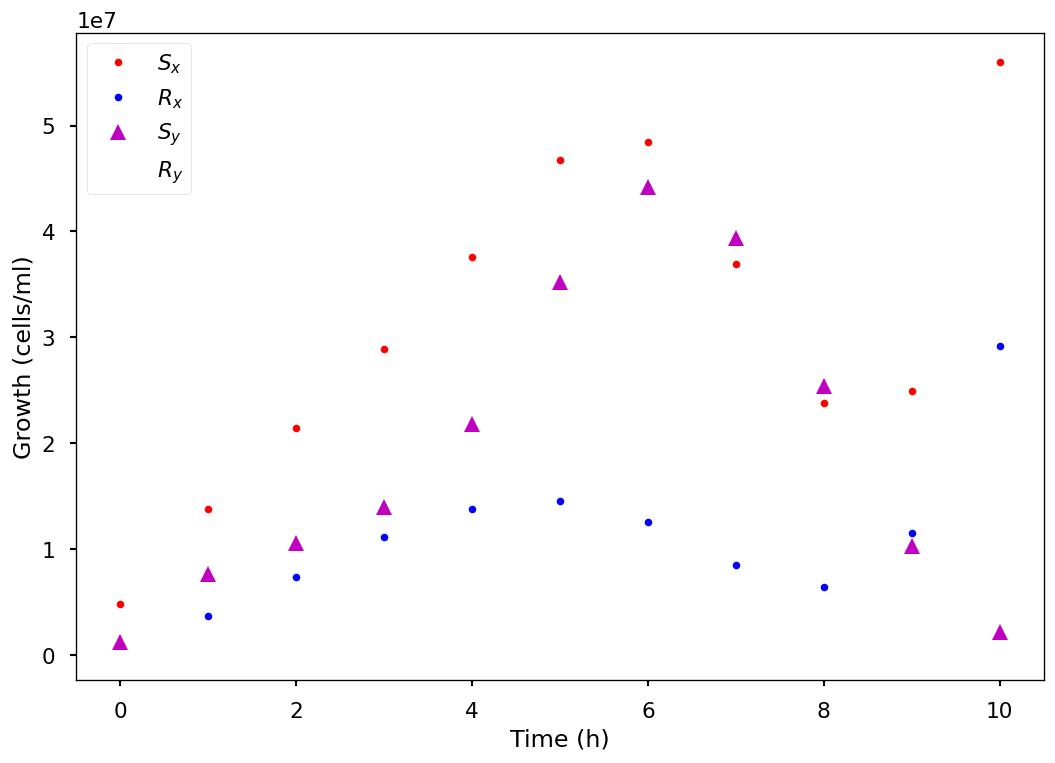

In [237]:
data=pd.read_csv("LB_lowamp_interpolated.csv")
y_obs=data[["S_x","R_x","S_y","R_y"]]
times = np.linspace(0, 1*(y_obs.shape[0]-1), y_obs.shape[0])

fig, ax = plt.subplots(dpi=120)
ax.plot(times, y_obs["S_x"],'r.', label=r"$S_x$")
ax.plot(times, y_obs["R_x"],'b.', label=r"$R_x$")
ax.plot(times, y_obs["S_y"],'m^', label=r"$S_y$")
ax.plot(times, y_obs["R_y"],'g+', label=r"$R_y$")
#ax.plot(times, y_obs["R_y"],color='orange', marker='^', label=r"$R_y$")
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('Growth (cells/ml)')  # Add a y-label to the axes.
ax.legend(loc='upper left')  # Add a legend.
plt.savefig( save_results_to + 'LB_lowamp_interpolated.pdf')

In [238]:
# data=pd.read_csv("LB_lowamp.csv")
# y_obs=data[["S_x","R_x","S_y","R_y"]]*1e8
# #times = np.linspace(0, 1*(y_obs.shape[0]-1), y_obs.shape[0])
# times = np.arange(0, 2*(y_obs.shape[0]-1)+2, 2)

# fig, ax = plt.subplots(dpi=120)
# ax.plot(times, y_obs["S_x"],'r*--', label=r"$S_x$")
# ax.plot(times, y_obs["R_x"],'b2--', label=r"$R_x$")
# ax.plot(times, y_obs["S_y"],'m^--', label=r"$S_y$")
# ax.plot(times, y_obs["R_y"],'g+--', label=r"$R_y$")
# #ax.plot(times, y_obs["R_y"],color='orange', marker='^', label=r"$R_y$")
# ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
# ax.set_ylabel('Growth (cells/ml)')  # Add a y-label to the axes.
# ax.legend(loc='upper left')  # Add a legend.
# plt.savefig( save_results_to + 'LB_lowamp.pdf')

In [239]:
print(times)
2*(y_obs.shape[0]-1)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


20

In [240]:
#data=pd.read_csv("LB_lowamp.csv")
data=pd.read_csv("LB_lowamp_interpolated.csv")
yobs_tmp=data[["S_x","R_x","S_y","R_y"]]
y_obs=yobs_tmp.to_numpy()
y_obs = y_obs.astype(int)
#y_obs=np.array([ y_obs_tmp[0:,0],y_obs_tmp[0:,1], y_obs_tmp[0:,2],y_obs_tmp[0:,3] ]).T

times = np.linspace(0, 1*(y_obs.shape[0]-1), y_obs.shape[0])

In [241]:
mydata = {}
mydata['n_obs']     = len(times) 
mydata['n_params']  = NumParams
mydata['n_difeq']   = NumEqs
mydata['n_sample']  = len(times)
mydata['n_fake']    = len(times)
mydata['y']         = y_obs
mydata['t0']        = -0.000001
mydata['ts']        = times
mydata['fake_ts']   = times

In [242]:
########################################
# Prior

kappa_alpha = 2.5
kappa_beta  = 1.
kappa_stan = 'gamma({alpha}, {beta})'.format(alpha=kappa_alpha, beta=kappa_beta)


K_alpha = 3
K_beta  = 1.
K_stan = 'gamma({alpha}, {beta})'.format(alpha=kappa_alpha, beta=kappa_beta)


gamma_x_alpha = 2.5
gamma_x_beta  = 1.
gamma_x_stan = 'gamma({alpha}, {beta})'.format(alpha=gamma_x_alpha, beta=gamma_x_beta)

gamma_y_alpha = 2.5
gamma_y_beta  = 1.
gamma_y_stan = 'gamma({alpha}, {beta})'.format(alpha=gamma_y_alpha, beta=gamma_y_beta)



# q_low  = 0.
# q_high = 1.
# q_stan = 'uniform({alpha}, {beta})'.format(alpha=q_low, beta=q_high)


q_alpha  = 2.5
q_beta   = 1.
q_stan   = 'gamma({alpha}, {beta})'.format(alpha=q_alpha, beta=q_beta)




s_x_0_low  = 1e5
s_x_0_high = 1e7
s_x_0_stan = 'uniform({alpha}, {beta})'.format(alpha=s_x_0_low, beta=s_x_0_high)


r_x_0_low  = 1e5
r_x_0_high = 5e7
r_x_0_stan = 'uniform({alpha}, {beta})'.format(alpha=r_x_0_low, beta=r_x_0_high)


s_y_0_low  = 1e5
s_y_0_high = 1e7
s_y_0_stan = 'uniform({alpha}, {beta})'.format(alpha=s_y_0_low, beta=s_y_0_high)


r_y_0_low  = 1e5
r_y_0_high = 5e7
r_y_0_stan = 'uniform({alpha}, {beta})'.format(alpha=r_y_0_low, beta=r_y_0_high)

In [243]:
# Fit
stan_code = """
functions {{
 real[] SIP(real t,       // time
               real[] y,     
               real[] params, // parameters
               real[] x_r,   // unused data
               int[] x_i) {{                 
    real dy_dt[4];

    real kappa   = params[1];
    real gamma_x = params[2];
    real gamma_y = params[3];
    real q       = params[4];
    

    real K     = 1.2e8;
    real a     = 0.01;
    real beta  = 2.;
    real F     = 1.5e5;
    real c     = .3;
    real delta = 0.15;

    
    dy_dt[1] = gamma_x*( y[1] + y[2] )*( (y[3] + y[4] + F)/( y[3] + y[4] + F + kappa) )* 
              (1- (y[1] + y[2] + y[3] + y[4])/K ) - q*c*y[1] - (1-q)*c*y[1] - delta*y[1]; 
    dy_dt[2] = a*gamma_x*( y[1] + y[2] )*((y[3] + y[4] + F)/( y[3] + y[4] + F + kappa) )* 
              (1- (y[1] + y[2] + y[3] + y[4])/K ) + q*c*y[1]  - delta*y[2];
    dy_dt[3] = gamma_y*( y[3] + y[4] )*((beta*( y[1] + y[2]) + F)/( beta*(y[1] + y[2]) + F + kappa) )* 
              (1- (y[1] + y[2] + y[3] + y[4])/K ) - q*c*y[3] - (1-q)*c*y[3] - delta*y[3];
    dy_dt[4] = a*gamma_y*( y[3] + y[4] )*((beta*(y[1] + y[2]) + F)/( beta*(y[1] + y[2]) + F + kappa) )* 
              (1- (y[1] + y[2] + y[3] + y[4])/K ) + q*c*y[3]  - delta*y[4];              
    
    return dy_dt;
  }}
}}

data {{
  int<lower = 1> n_obs; // Number of days sampled
  int<lower = 1> n_params; // Number of model parameters
  int<lower = 1> n_difeq; // Number of differential equations in the system
  int<lower = 1> n_sample; // Number of hosts sampled at each time point.
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data

  int y[n_obs, 4]; // The binomially distributed data
  real t0; // Initial time point (zero)
  real ts[n_obs]; // Time points that were sampled  
  real fake_ts[n_fake]; // Time points for "predicted"/"unsampled" data  
}}

transformed data {{
  real x_r[0];
  int x_i[0];
}}

parameters {{
  //Support of parameters
  real<lower =  5e4, upper = 5e8>  kappa;
  real<lower =  0, upper = 1e1>  gamma_x;
  real<lower =  0, upper = 1e1>  gamma_y;
  real<lower =  0.0, upper = 0.5>  q;
  real<lower =  1e5, upper = 1e7> S_x_0 ;
  real<lower =  1e5, upper = 5e7> R_x_0; 
  real<lower =  1e5, upper = 1e7> S_y_0 ;
  real<lower =  1e5, upper = 5e7> R_y_0;
  
  //Standard deviation of likelihood distribution
//  real sigma[4];   // measurement errors 
}}

transformed parameters {{
  real params[4]; 
  real y_hat[n_obs, n_difeq]; // Output from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I

  y_init[1] = S_x_0;
  y_init[2] = R_x_0;
  y_init[3] = S_y_0;
  y_init[4] = R_y_0;
  
  params[1] = kappa;
  params[2] = gamma_x;
  params[3] = gamma_y;
  params[4] = q; 
  
  y_hat = integrate_ode_rk45(SIP, y_init, t0, ts, params, x_r, x_i);
  
}}

model {{ 
  // Prior distributions
  kappa    ~ {Kappa}; 
  gamma_x  ~ {Gamma_x}; 
  gamma_y  ~ {Gamma_y};
  q        ~ {Q};
  S_x_0    ~ {Sx0};
  R_x_0    ~ {Rx0};
  S_y_0    ~ {Sy0};
  R_y_0    ~ {Ry0};  
//  sigma ~ normal(0, 10);  
  for (k in 1:4){{
     y[ , k] ~ poisson(y_hat[, k]);
  }}
}}

generated quantities {{
  // Generate predicted data over the whole time series:
                    
  real K     = 1.2e8;
  real a     = 0.01;
  real beta  = 2.;
  real F     = 1.5e5;
  real c     = 0.3;
  real delta = 0.15; 

  
  real fake[n_fake, n_difeq];
  
  fake = integrate_ode_rk45(SIP, y_init, t0, fake_ts, params, x_r, x_i);
  
//  for (k in 1:4){{
//      fake[ ,k] = normal_rng( y_hat_fake[, k] ,sigma[k]);
//  }}


}}
""".format(
        Kappa   = kappa_stan,
        Gamma_x = gamma_x_stan,
        Gamma_y = gamma_y_stan,
        Q       = q_stan,
        Sx0     = s_x_0_stan,
        Rx0     = r_x_0_stan,
        Sy0     = s_y_0_stan,
        Ry0     = r_y_0_stan    
        )

In [244]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722 NOW.
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:771:
/home/kernel/anaconda3/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~
In file included from /home/ker

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/products/GeneralMat

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

In file included from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:0,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/kernel/anaconda3/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_syxxne73/stanfit4anon_model_b1c56a04bfc2c1d9efceb1ff89c0b722_4618713278130302419.cpp:780:
/home/kernel/anaconda3/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h: 

--- 28.58158588409424 seconds ---


In [245]:
# # do the fitting
# start_time = time.time()
# fit = sm.sampling(
#                   data=mydata,
#                   iter=NumIter,
# #                  init='0',
#                   chains=NumChains,
#                   warmup=burnin,
#                   seed=431,
#                   verbose=True,
#                   algorithm='NUTS',
#                   control={"adapt_delta": 0.9}
#                   )
# print("--- %s seconds ---" % (time.time() - start_time))

In [246]:
start_time = time.time()
fit = sm.vb(
                  data=mydata,
                  iter=Num_Iter,
                  seed=431,
                  sample_file = save_results_to + "mibi_results.csv",    
                  verbose=True,
#                  algorithm='meanfield'
                  algorithm='fullrank'
#                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
EXPERIMENTAL ALGORITHM:
  This procedure has not been thoroughly tested and may be unstable
  or buggy. The interface is subject to change.
------------------------------------------------------------



Gradient evaluation took 0.00291 seconds
1000 transitions using 10 leapfrog steps per transition would take 29.1 seconds.
Adjust your expectations accordingly!


Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100   -155612692.298             1.000            1.000
   200   -116040680.108             0.671            1.000
   300    -98330883.573             0.5

In [247]:
advi_results=pd.read_csv(save_results_to + "mibi_results.csv",comment='#')

In [248]:
#print( advi_results.columns.tolist() )

In [249]:
fake_1 =advi_results.loc[:,"fake.1.1":"fake.11.1"]
fake_2 =advi_results.loc[:,"fake.1.2":"fake.11.2"]
fake_3 =advi_results.loc[:,"fake.1.3":"fake.11.3"]
fake_4 =advi_results.loc[:,"fake.1.4":"fake.11.4"]

In [250]:
median_ppc=np.zeros((len(times),y_obs.shape[0]))
CriL_ppc  =np.zeros((len(times),y_obs.shape[0]))
CriU_ppc  =np.zeros((len(times),y_obs.shape[0]))

In [251]:
median_ppc[:,0]=np.percentile(fake_1,q=50.,axis=0)
CriL_ppc[:,0]  =np.percentile(fake_1,q=2.5,axis=0)
CriU_ppc[:,0]  =np.percentile(fake_1,q=97.5,axis=0)

median_ppc[:,1]=np.percentile(fake_2,q=50.,axis=0)
CriL_ppc[:,1]  =np.percentile(fake_2,q=2.5,axis=0)
CriU_ppc[:,1]  =np.percentile(fake_2,q=97.5,axis=0)

median_ppc[:,2]=np.percentile(fake_3,q=50.,axis=0)
CriL_ppc[:,2]  =np.percentile(fake_3,q=2.5,axis=0)
CriU_ppc[:,2]  =np.percentile(fake_3,q=97.5,axis=0)

median_ppc[:,3]=np.percentile(fake_4,q=50.,axis=0)
CriL_ppc[:,3]  =np.percentile(fake_4,q=2.5,axis=0)
CriU_ppc[:,3]  =np.percentile(fake_4,q=97.5,axis=0)

In [252]:
ppc_kappa   =advi_results["kappa"]
ppc_gamma_x =advi_results["gamma_x"]
ppc_gamma_y =advi_results["gamma_y"]
ppc_q =advi_results["q"]

ppc_S_x_0   =advi_results["S_x_0"]
ppc_R_x_0   =advi_results["R_x_0"]
ppc_S_y_0   =advi_results["S_y_0"]
ppc_R_y_0   =advi_results["R_y_0"]

In [253]:
CriL_ppc_kappa = np.percentile(ppc_kappa,q=2.5,axis=0)
CriU_ppc_kappa = np.percentile(ppc_kappa,q=97.5,axis=0)

CriL_ppc_gamma_x = np.percentile(ppc_gamma_x,q=2.5,axis=0)
CriU_ppc_gamma_x = np.percentile(ppc_gamma_x,q=97.5,axis=0)

CriL_ppc_gamma_y = np.percentile(ppc_gamma_y,q=2.5,axis=0)
CriU_ppc_gamma_y = np.percentile(ppc_gamma_y,q=97.5,axis=0)

CriL_ppc_q = np.percentile(ppc_q,q=2.5,axis=0)
CriU_ppc_q = np.percentile(ppc_q,q=97.5,axis=0)


CriL_ppc_S_x_0 = np.percentile(ppc_S_x_0,q=2.5,axis=0)
CriU_ppc_S_x_0 = np.percentile(ppc_S_x_0,q=97.5,axis=0)

CriL_ppc_R_x_0 = np.percentile(ppc_R_x_0,q=2.5,axis=0)
CriU_ppc_R_x_0 = np.percentile(ppc_R_x_0,q=97.5,axis=0)

CriL_ppc_S_y_0 = np.percentile(ppc_S_y_0,q=2.5,axis=0)
CriU_ppc_S_y_0 = np.percentile(ppc_S_y_0,q=97.5,axis=0)

CriL_ppc_R_y_0 = np.percentile(ppc_R_y_0,q=2.5,axis=0)
CriU_ppc_R_y_0 = np.percentile(ppc_R_y_0,q=97.5,axis=0)

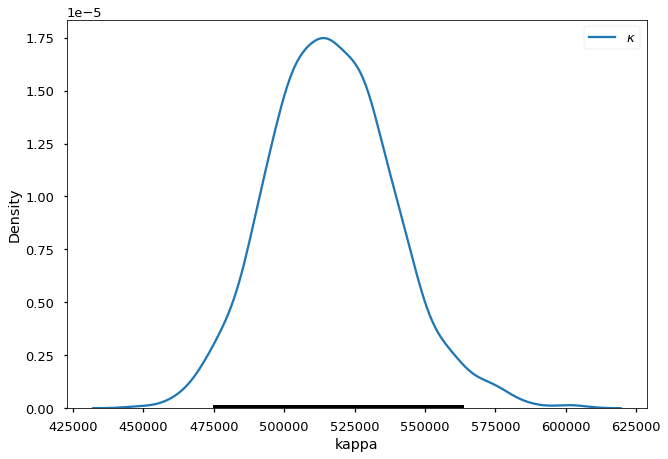

In [254]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_kappa,label=r'$\kappa$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_kappa, CriU_ppc_kappa]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-kappa.eps')

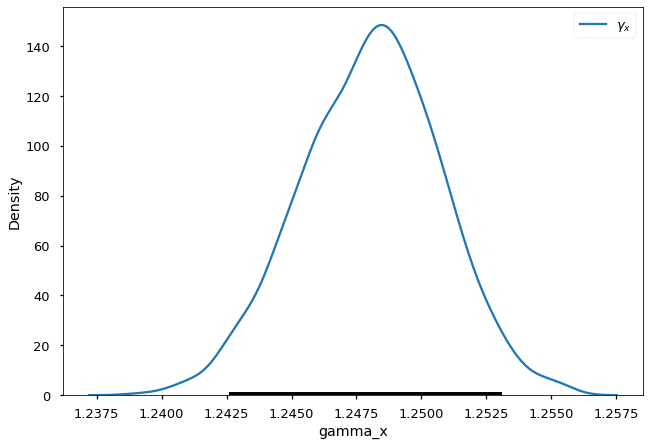

In [255]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_gamma_x,label=r'$\gamma_x$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_gamma_x, CriU_ppc_gamma_x]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-gamma_x.eps')

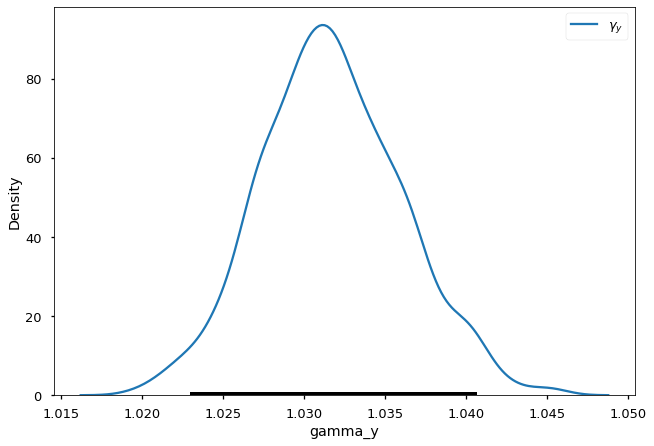

In [256]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_gamma_y,label=r'$\gamma_y$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_gamma_y, CriU_ppc_gamma_y]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-gamma_y.eps')

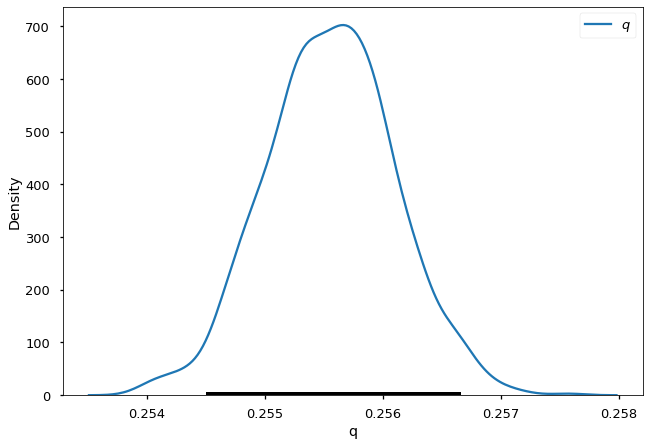

In [257]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_q,label=r'$q$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_q, CriU_ppc_q]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-q.eps')

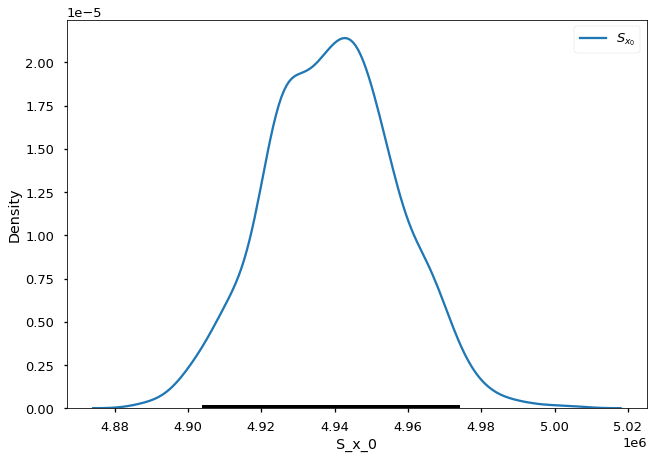

In [258]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_S_x_0,label=r'$S_{x_0}$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_S_x_0, CriU_ppc_S_x_0]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-S_x_0.eps')

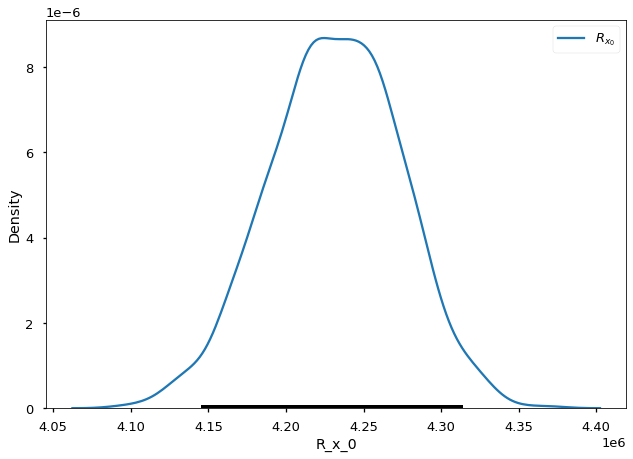

In [259]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_R_x_0,label=r'$R_{x_0}$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_R_x_0, CriU_ppc_R_x_0]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-R_x_0.eps')

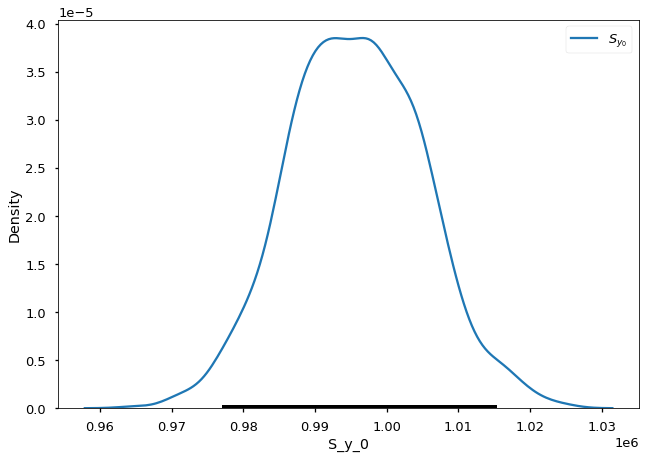

In [260]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_S_y_0,label=r'$S_{y_0}$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_S_y_0, CriU_ppc_S_y_0]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-S_y_0.eps')

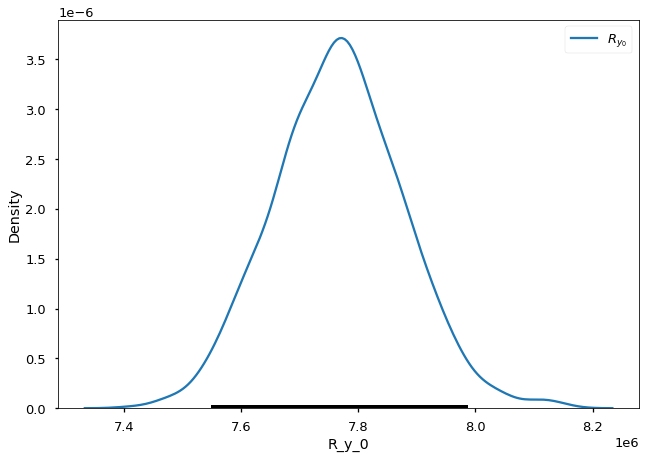

In [261]:
plt.figure(facecolor="white")
sns.kdeplot(data=ppc_R_y_0,label=r'$R_{y_0}$')
#    plt.axvline(x=CriL_ppc_beta_s,color='r',linestyle="--")
#    plt.axvline(x=CriU_ppc_beta_s,color='r',linestyle="--")
x_values = [CriL_ppc_R_y_0, CriU_ppc_R_y_0]
y_values = [0, 0]
plt.plot(x_values, y_values,color='k', lw=6)
plt.legend()  # Add a legend.
plt.savefig(save_results_to + 'BayesianInterval-R_y_0.eps')

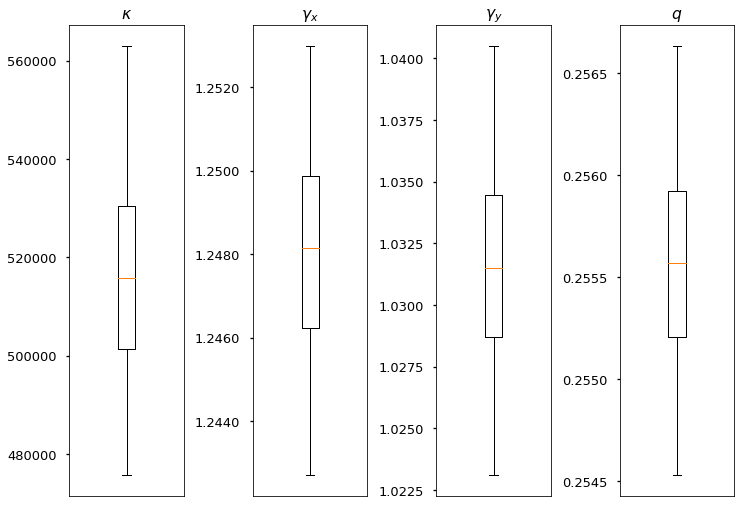

In [262]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
fig, axs = plt.subplots(1, 4)


axs[0].boxplot(ppc_kappa,whis=(2.5,97.5), sym='')
axs[0].set_title(r'$\kappa$')
axs[0].set_xticks([])

axs[1].boxplot(ppc_gamma_x,whis=(2.5,97.5), sym='')
axs[1].set_title(r'$\gamma_x$')
axs[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: "{:.4f}".format(float(x), ',')))
axs[1].set_xticks([])

axs[2].boxplot(ppc_gamma_y,whis=(2.5,97.5), sym='')
axs[2].set_title(r'$\gamma_y$')
axs[2].set_xticks([])


axs[3].boxplot(ppc_q,whis=(2.5,97.5), sym='')
axs[3].set_title(r'$q$')
axs[3].set_xticks([])

#color ='violet'
plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_FullRank.eps')

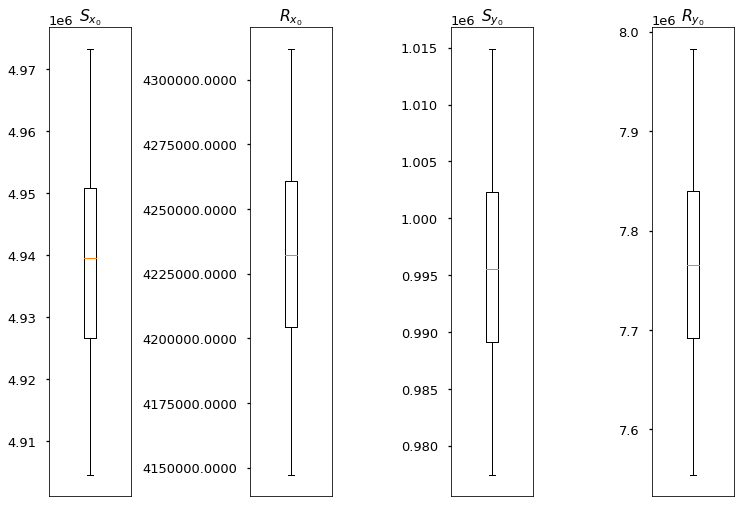

In [263]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
fig, axs = plt.subplots(1, 4)


axs[0].boxplot(ppc_S_x_0,whis=(2.5,97.5), sym='')
axs[0].set_title(r'$S_{x_0}$')
axs[0].set_xticks([])

axs[1].boxplot(ppc_R_x_0,whis=(2.5,97.5), sym='')
axs[1].set_title(r'$R_{x_0}$')
axs[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: "{:.4f}".format(float(x), ',')))
axs[1].set_xticks([])

axs[2].boxplot(ppc_S_y_0,whis=(2.5,97.5), sym='')
axs[2].set_title(r'$S_{y_0}$')
axs[2].set_xticks([])


axs[3].boxplot(ppc_R_y_0,whis=(2.5,97.5), sym='')
axs[3].set_title(r'$R_{y_0}$')
axs[3].set_xticks([])

#color ='violet'
plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_IniCond.eps')

In [264]:
sampleT=advi_results.loc[:,"kappa":"q"]

In [265]:
map=np.median(sampleT,axis=0)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 748.8x514.8 with 0 Axes>

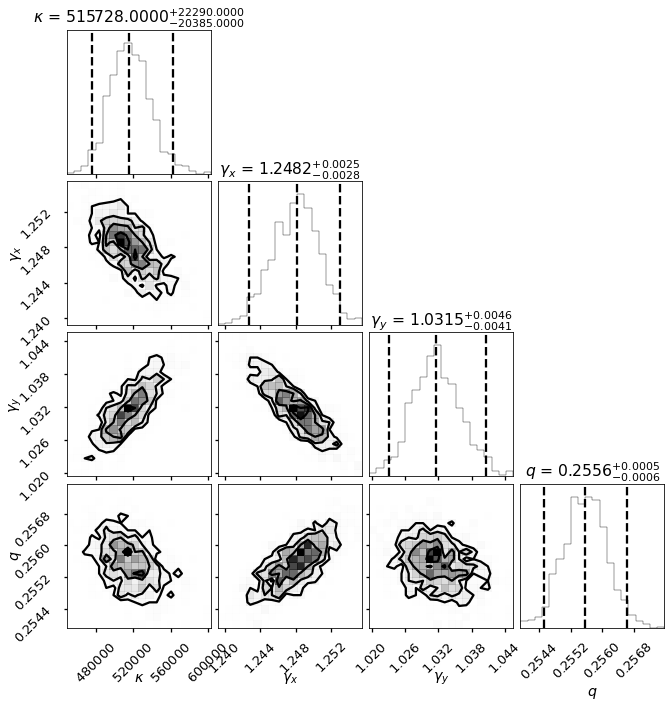

In [266]:
varnames=[r"$\kappa$", r"$\gamma_{x}$" , r"$\gamma_{y}$", r"$q$"]
plt.figure()
corner.corner(sampleT,show_titles=True,labels=varnames,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
             use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'cornerCovMob0.pdf')

<Figure size 748.8x514.8 with 0 Axes>

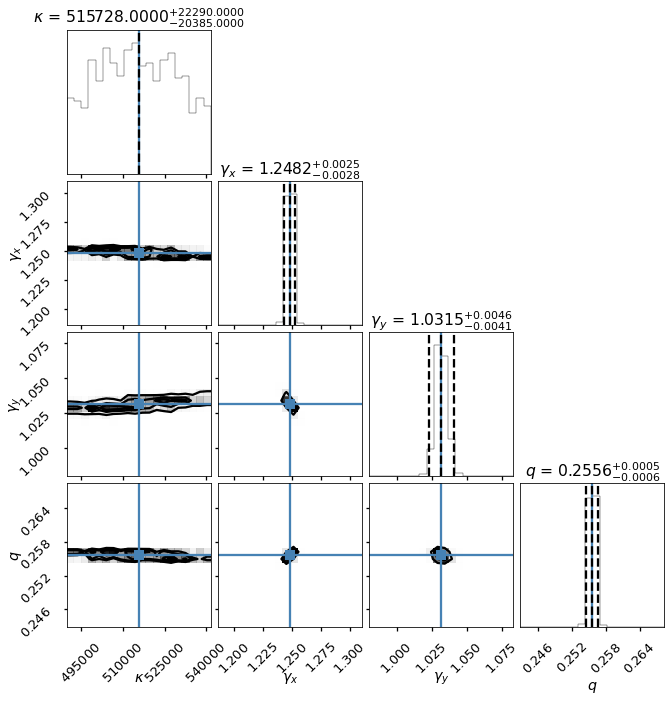

In [267]:
range = np.array([(0.95*x,1.05*x) for x in map])
plt.figure()
corner.corner(sampleT,show_titles=True,labels=varnames,truths=map,range=range,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
              use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'corner_CovMob1.pdf')

In [268]:
sampleT=advi_results.loc[:,"S_x_0":"R_y_0"]

In [269]:
map=np.median(sampleT,axis=0)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 748.8x514.8 with 0 Axes>

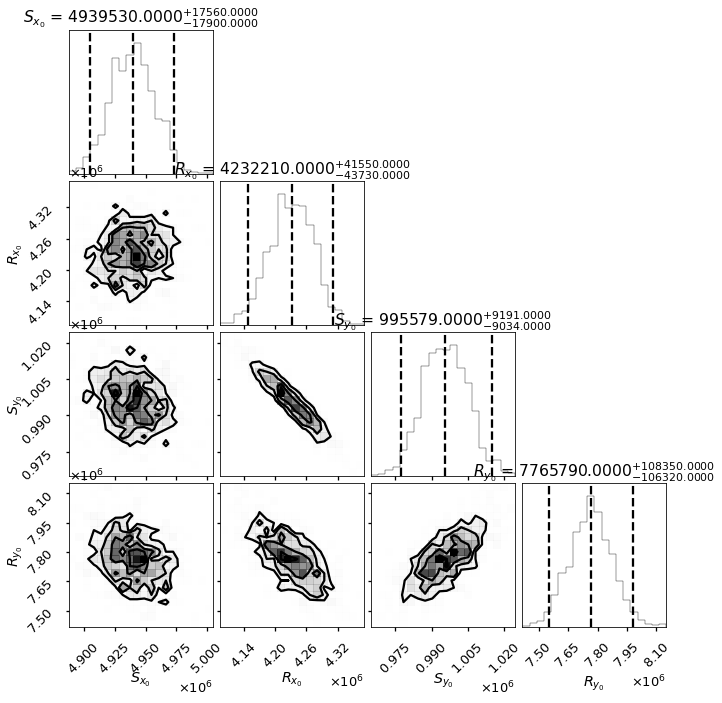

In [270]:
varnames=[r"$S_{x_0}$", r"$R_{x_0}$" , r"$S_{y_0}$", r"$R_{y_0}$"]
plt.figure()
corner.corner(sampleT,show_titles=True,labels=varnames,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
             use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'cornerCovMob0_IniCond.pdf')

<Figure size 748.8x514.8 with 0 Axes>

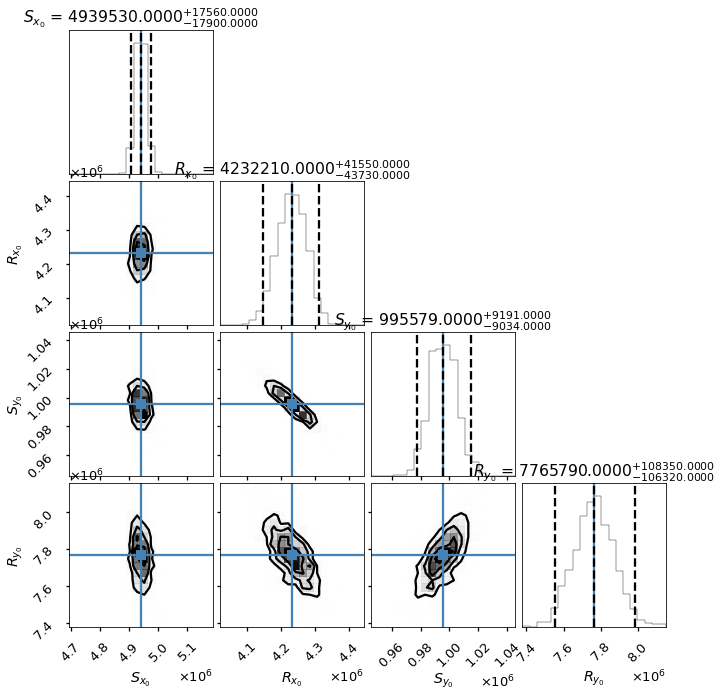

In [271]:
range = np.array([(0.95*x,1.05*x) for x in map])
plt.figure()
corner.corner(sampleT,show_titles=True,labels=varnames,truths=map,range=range,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975],
              use_math_text=True,title_fmt='.4f')
plt.savefig(save_results_to +'corner_CovMob1_IniCond.pdf')

In [272]:
pd.options.display.float_format = "{:.4f}".format
df0 = advi_results.loc[:,"kappa":"q"].describe()

In [273]:
temp_df = df0.drop(["count"], axis=0)

In [274]:
df = temp_df.rename(columns={'kappa': r"$\kappa$", 
                             'gamma_x': r"$\gamma_{x}$", 
                             'gamma_y': r"$\gamma_{x}$",
                             'q': r"$q$"
                            })                          

In [275]:
df.T

,mean,std,min,25%,50%,75%,max
$\kappa$,516901.7712,22010.6519,448746.0000,501446.0000,515728.0000,530459.0000,602908.0000
$\gamma_{x}$,1.2480,0.0027,1.2392,1.2462,1.2482,1.2499,1.2555
$\gamma_{x}$,1.0317,0.0043,1.0195,1.0287,1.0315,1.0345,1.0455
$q$,0.2556,0.0005,0.2539,0.2552,0.2556,0.2559,0.2576


In [276]:
with open('Table_Mibi.tex','w') as tf:
     tf.write(df.T.to_latex())

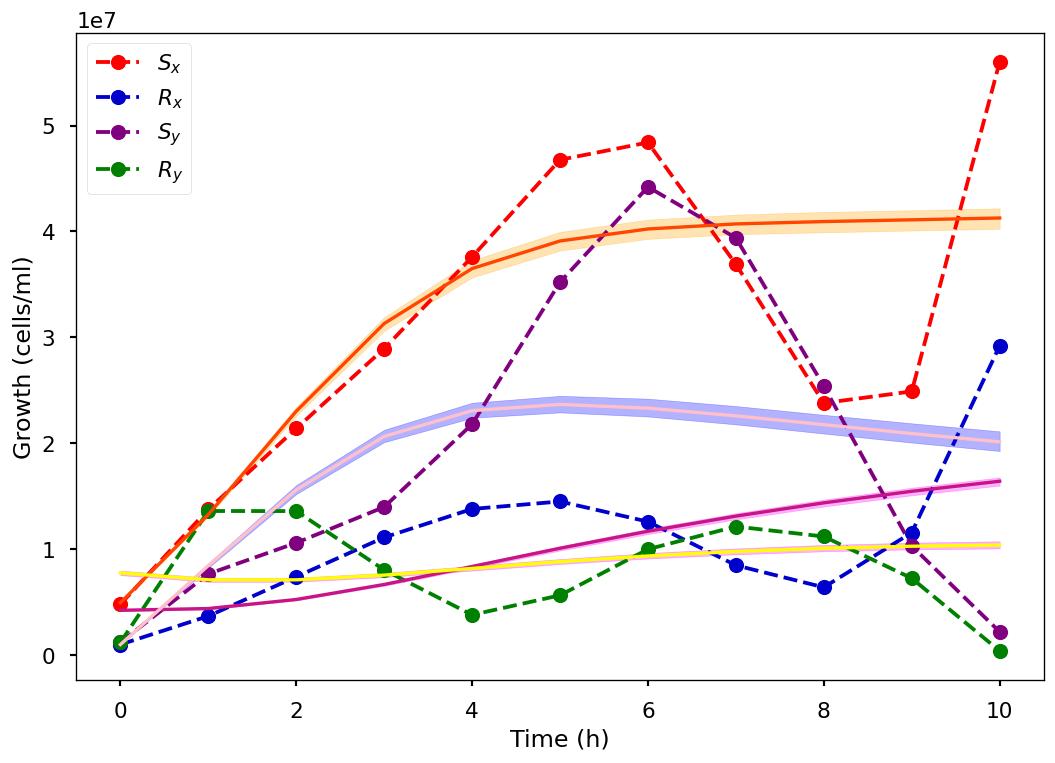

In [277]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='red',label=r'$S_{x}$')
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='mediumblue',label=r'$R_{x}$')
ax.plot(times,y_obs[:,2], linestyle='dashed', marker='o', 
        color='purple',label=r'$S_{y}$')
ax.plot(times,y_obs[:,3], linestyle='dashed', marker='o', 
        color='green',label=r'$R_{y}$')
ax.plot(times,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.plot(times,median_ppc[:,2], color='pink', lw=2)
ax.plot(times,median_ppc[:,3], color='yellow', lw=2)
ax.fill_between(times,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times,CriL_ppc[:,1],CriU_ppc[:,1],  color='magenta', alpha=0.3)
ax.fill_between(times,CriL_ppc[:,2],CriU_ppc[:,2], color='b', alpha=0.3)
ax.fill_between(times,CriL_ppc[:,3],CriU_ppc[:,3],  color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('Growth (cells/ml)')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc='upper left')  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands.pdf')

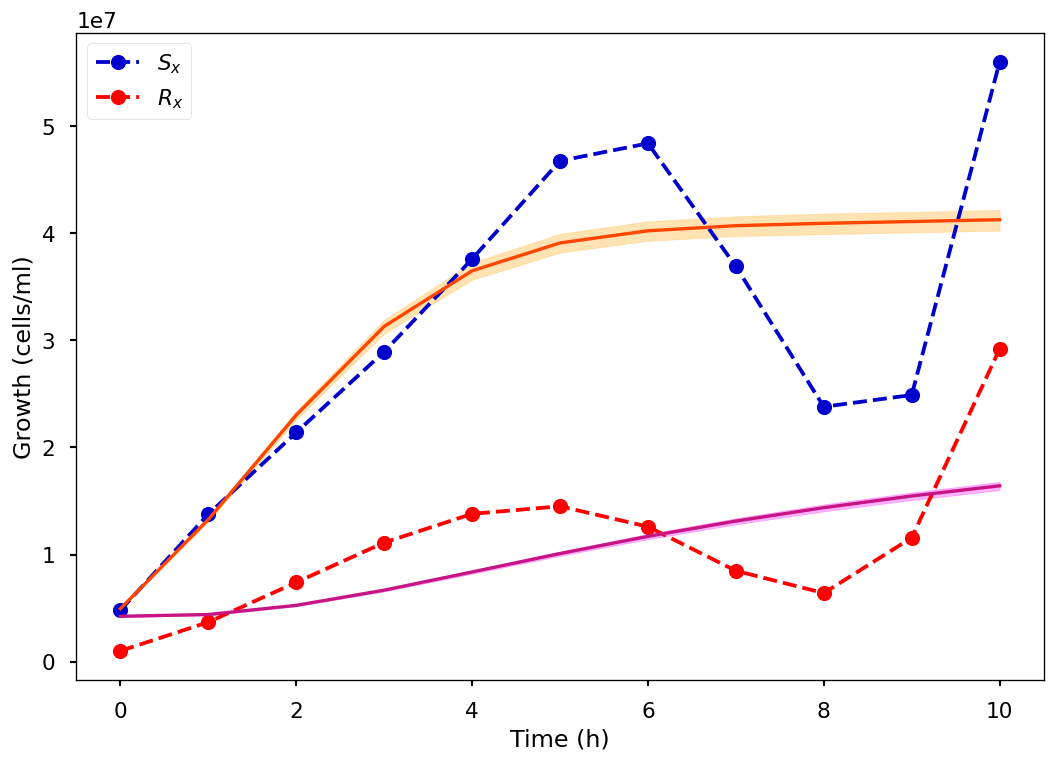

In [278]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label=r'$S_{x}$')
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label=r'$R_{x}$')
ax.plot(times,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times,CriL_ppc[:,1],CriU_ppc[:,1],  color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('Growth (cells/ml)')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc='upper left')  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands_x.pdf')

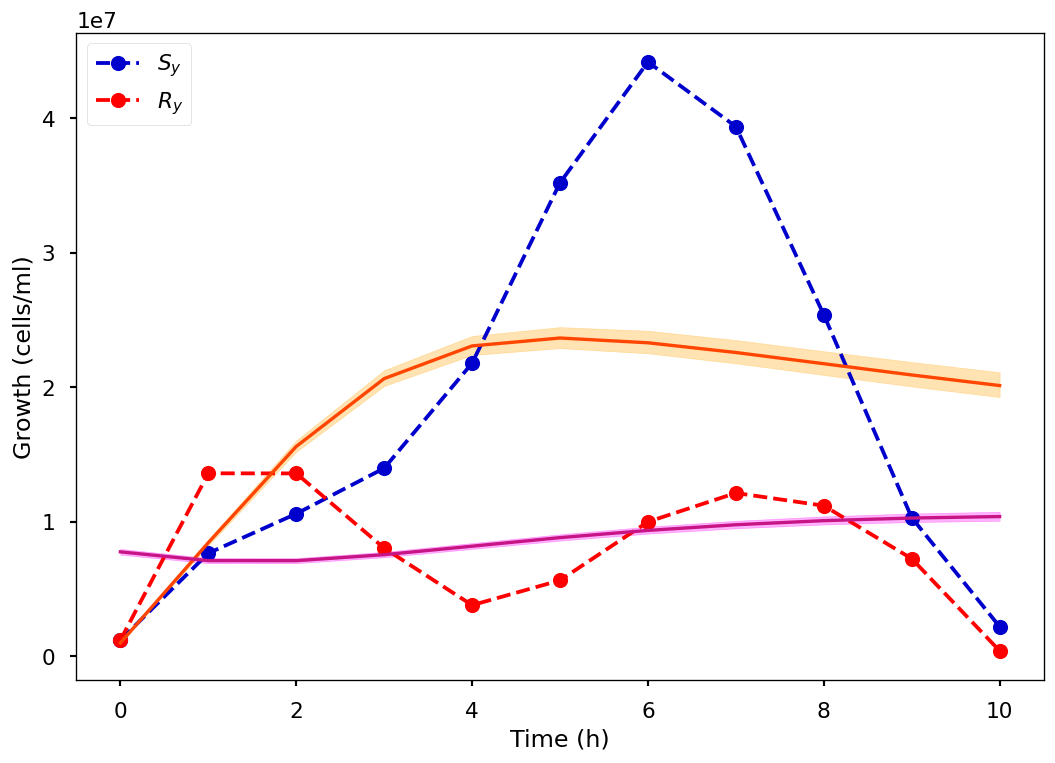

In [279]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,2], linestyle='dashed', marker='o', 
        color='mediumblue',label=r'$S_{y}$')
ax.plot(times,y_obs[:,3], linestyle='dashed', marker='o', 
        color='red',label=r'$R_{y}$')
ax.plot(times,median_ppc[:,2], color='orangered', lw=2)
ax.plot(times,median_ppc[:,3], color='mediumvioletred', lw=2)
ax.fill_between(times,CriL_ppc[:,2],CriU_ppc[:,2], color='orange', alpha=0.3)
ax.fill_between(times,CriL_ppc[:,3],CriU_ppc[:,3],  color='magenta', alpha=0.3)
ax.set_xlabel('Time (h)')  # Add an x-label to the axes.
ax.set_ylabel('Growth (cells/ml)')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc='upper left')  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands_y.pdf')